In [2]:
import torchviz
from torchviz import make_dot

In [3]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/__init__.py
import argparse
import os
import shutil
import pdb, time
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# from utils import convert_secs2time, time_string, time_file_str
import models
import numpy as np

model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))




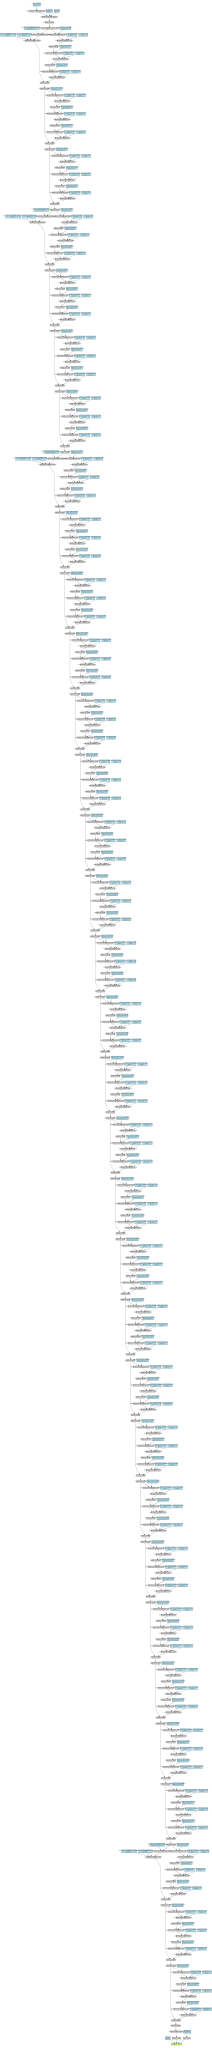

In [7]:
from torchviz import make_dot
model = models.__dict__['resnet101'](pretrained=False)
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = model(x)
make_dot(out, params=dict(model.named_parameters()))

In [3]:

from dotmap import DotMap

args = DotMap()




args.description = 'Pytorch imangenet training'
args.data = '/home/hongky/datasets/imagenet'
args.save_dir = './logs/0508_resnet101_rate_0.7_infer_model_withzero/'
args.arch = 'resnet101'
args.workers = 4
args.batch_size = 64
args.learning_rate = 0.1
args.print_freq = 100
args.resume = '0510_resnet101/resnet101-rate-0.7/best.resnet101.2020-10-05-6841.pth.tar'
args.rate = 0.9
args.epoch_prune = 1
args.skip_downsample=1
args.evaluate = True 
args.eval_small = False 
args.small_model = ''

args.use_cuda = torch.cuda.is_available()


print(args)


DotMap(description='Pytorch imangenet training', data='/home/hongky/datasets/imagenet', save_dir='./logs/0508_resnet101_rate_0.7_infer_model_withzero/', arch='resnet101', workers=4, batch_size=64, learning_rate=0.1, print_freq=100, resume='0510_resnet101/resnet101-rate-0.7/best.resnet101.2020-10-05-6841.pth.tar', rate=0.9, epoch_prune=1, skip_downsample=1, evaluate=True, eval_small=False, small_model='', use_cuda=True)


In [4]:
def validate(val_loader, model, criterion, log):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        # target = target.cuda(async=True)
        if args.use_cuda:
            input, target = input.cuda(), target.cuda(non_blocking=True)
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))
        top5.update(prec5.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print_log('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                i, len(val_loader), batch_time=batch_time, loss=losses,
                top1=top1, top5=top5), log)

    print_log(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Error@1 {error1:.3f}'.format(top1=top1, top5=top5,
                                                                                           error1=100 - top1.avg), log)

    return top1.avg


def print_log(print_string, log):
    print("{}".format(print_string))
    log.write('{}\n'.format(print_string))
    log.flush()


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def remove_module_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v
    return new_state_dict



In [5]:
best_prec1 = 0

if not os.path.isdir(args.save_dir):
    os.makedirs(args.save_dir)
log = open(os.path.join(args.save_dir, 'gpu-time.{}.log'.format(args.arch)), 'w')

# create model
print_log("=> creating model '{}'".format(args.arch), log)
model = models.__dict__[args.arch](pretrained=False)
print_log("=> Model : {}".format(model), log)
print_log("=> parameter : {}".format(args), log)
print_log("Compress Rate: {}".format(args.rate), log)
print_log("Epoch prune: {}".format(args.epoch_prune), log)
print_log("Skip downsample : {}".format(args.skip_downsample), log)


=> creating model 'resnet101'
=> Model : ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d

In [6]:

# optionally resume from a checkpoint
if args.resume:
    if os.path.isfile(args.resume):
        print_log("=> loading checkpoint '{}'".format(args.resume), log)
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        state_dict = checkpoint['state_dict']
        state_dict = remove_module_dict(state_dict)
        model.load_state_dict(state_dict)
        print_log("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']), log)
    else:
        print_log("=> no checkpoint found at '{}'".format(args.resume), log)

cudnn.benchmark = True


=> loading checkpoint '0510_resnet101/resnet101-rate-0.7/best.resnet101.2020-10-05-6841.pth.tar'
=> loaded checkpoint '0510_resnet101/resnet101-rate-0.7/best.resnet101.2020-10-05-6841.pth.tar' (epoch 10)


In [7]:

# Data loading code
valdir = os.path.join(args.data, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        # transforms.Scale(256),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)

criterion = nn.CrossEntropyLoss().cuda()


In [8]:

if args.evaluate:
    print_log("eval true", log)
    if not args.eval_small:
        big_model = model.cuda()
        print_log('Evaluate: big model', log)
        print_log('big model accu: {}'.format(validate(val_loader, big_model, criterion, log)), log)
    else:
        print_log('Evaluate: small model', log)
        if args.small_model:
            if os.path.isfile(args.small_model):
                print_log("=> loading small model '{}'".format(args.small_model), log)
                small_model = torch.load(args.small_model)
                for x, y in zip(small_model.named_parameters(), model.named_parameters()):
                    print_log("name of layer: {}\n\t *** small model {}\n\t *** big model {}".format(x[0], x[1].size(),
                                                                                                     y[1].size()), log)
                if args.use_cuda:
                    small_model = small_model.cuda()
                print_log('small model accu: {}'.format(validate(val_loader, small_model, criterion, log)), log)
            else:
                print_log("=> no small model found at '{}'".format(args.small_model), log)

eval true
Evaluate: big model


/home/hongky/.conda/envs/mdc/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app
/home/hongky/.conda/envs/mdc/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


Test: [0/782]	Time 7.448 (7.448)	Loss 0.9352 (0.9352)	Prec@1 84.375 (84.375)	Prec@5 89.062 (89.062)
Test: [100/782]	Time 1.496 (0.762)	Loss 0.9383 (1.1372)	Prec@1 75.000 (71.705)	Prec@5 90.625 (90.223)
Test: [200/782]	Time 0.348 (0.809)	Loss 0.8962 (1.1529)	Prec@1 82.812 (70.149)	Prec@5 92.188 (90.990)
Test: [300/782]	Time 0.100 (0.802)	Loss 0.7206 (1.1435)	Prec@1 75.000 (70.375)	Prec@5 93.750 (91.066)
Test: [400/782]	Time 0.098 (0.811)	Loss 1.1970 (1.2807)	Prec@1 67.188 (67.538)	Prec@5 92.188 (89.187)
Test: [500/782]	Time 0.106 (0.821)	Loss 0.5875 (1.3420)	Prec@1 85.938 (66.567)	Prec@5 96.875 (88.167)
Test: [600/782]	Time 0.098 (0.798)	Loss 1.2794 (1.3934)	Prec@1 78.125 (65.643)	Prec@5 87.500 (87.451)
Test: [700/782]	Time 0.098 (0.796)	Loss 1.1043 (1.4410)	Prec@1 75.000 (64.702)	Prec@5 93.750 (86.700)
 * Prec@1 64.704 Prec@5 86.688 Error@1 35.296
big model accu: 64.704


In [3]:
!nvidia-smi
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

Wed Oct  7 21:30:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   41C    P0    73W / 300W |  15974MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   43C    P0    70W / 300W |  15074MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T